In [276]:
import pandas as pd
import numpy as np

from mothernet.evaluation.cd_plot_new.cd_plot_code import cd_evaluation
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", FutureWarning)

varies_over_time = ['XGBoost', 'RF', 'MLP', 'KNN', 'LogReg']

validation_result_file = "results_validation_2024-05-09.csv"
#test_result_file = 'results_test_2024-04-18.csv'
test_result_file = None

valid_results = pd.read_csv(validation_result_file, index_col=0)
rename_dict = {#'additive_Dclass_average_factorizedoutputTrue_w001_03_02_2024_02_21_10_epoch_420': 'additive class average factorized',
                                                      'additive_Dclass_average_02_29_2024_04_15_55_epoch_1050': 'additive_class_average',
                                                      'additive_1_gpu_02_14_2024_16_34_15': 'additive dense',
                                           #         'mn_Dclass_average_02_29_2024_04_16_00_ohe_ensemble_32_again': 'MotherNet',
                                                    'MotherNet': 'mothernet_old',
                                                     'additive_Dclass_average_multiclassmaxsteps3_multiclasstypesteps_03_04_2024_19_04_03_epoch_270': 'steps_prior',
                                                     #'baam_nfeatures_20_no_ensemble_e1520': 'GammaNet',
    'batapfn_no_ensemble_e410': 'bi-attention TabPFN',
    'ebm_default': 'EBM (interactions)',
    'ebm_bins_main_effects': 'EBM (main effects)',
    'hyperfast_no_optimize_gpu': 'HyperFast no gradient descent',
    'hyperfast_defaults_gpu' : 'HyperFast default parameters',
    'LogReg': 'Logistic Regression',
     'RF': 'RandomForest',
    'MLP-Distill': 'mlp_distill',
    'MLP': 'Neural Network',
    'TabPFN (ours)': 'tabpfn_ours_hide'}
#valid_results.model.unique()
valid_results['model'] = valid_results.model.replace({'hyperfast_defaults_cpu': 'hyperfast_defaults_gpu'}) ## HACCCKKK
valid_results['model'] = valid_results.model.replace(rename_dict)
valid_results = valid_results[valid_results.model != "hyperfast_no_optimize_cpu"]
all_models = valid_results.model.unique()

#valid_results = valid_results[~valid_results.model.str.contains('_')]

In [277]:
all_models

array(['KNN', 'RandomForest', 'XGBoost', 'Logistic Regression',
       'Neural Network', 'mothernet_old', 'mlp_distill',
       'TabPFN (Hollmann)', 'tabpfn_ours_hide', 'tabpfn_ours_ensemble_8',
       'tabpfn_ours_ensemble_32',
       'batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e630',
       'batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130',
       'EBM (interactions)', 'EBM (main effects)',
       'mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8',
       'mn_Dclass_average_fourierfeatures16_05_09_2024_01_03_23_epoch_100',
       'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490',
       'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1780',
       'baam_nsamples500_numfeatures20_04_04_2024_03_07_12_epoch_1210',
       'additive_class_average',
       'baam_e128_nsamples500_numfeatures20_04_01_2024_15_38_54_epoch_2220',
       'baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_5

In [278]:
if test_result_file:
    test_results = pd.read_csv(test_result_file, index_col=0)
    test_results['model'] = test_results.model.replace(rename_dict)
    all_models = set(valid_results.model.unique()).union(set(test_results.model.unique()))

    print(test_results.model.unique())
    print(valid_results.model.unique())
    assert set(test_results.model.unique()) == set(valid_results.model.unique())

In [279]:
color_palette = sns.color_palette(n_colors=len(all_models))
color_mapping = dict(zip(all_models, color_palette))

In [280]:
def get_best_over_time(results):
    average_over_splits = results.groupby(["dataset", "model", "max_time"])[["mean_metric", "fit_time", "inference_time"]].mean().reset_index()
    best_tuned = average_over_splits[average_over_splits.max_time == average_over_splits.max_time.max()]
    untuned = average_over_splits[~average_over_splits.model.isin(best_tuned.model.unique())]
    return pd.concat([best_tuned, untuned])

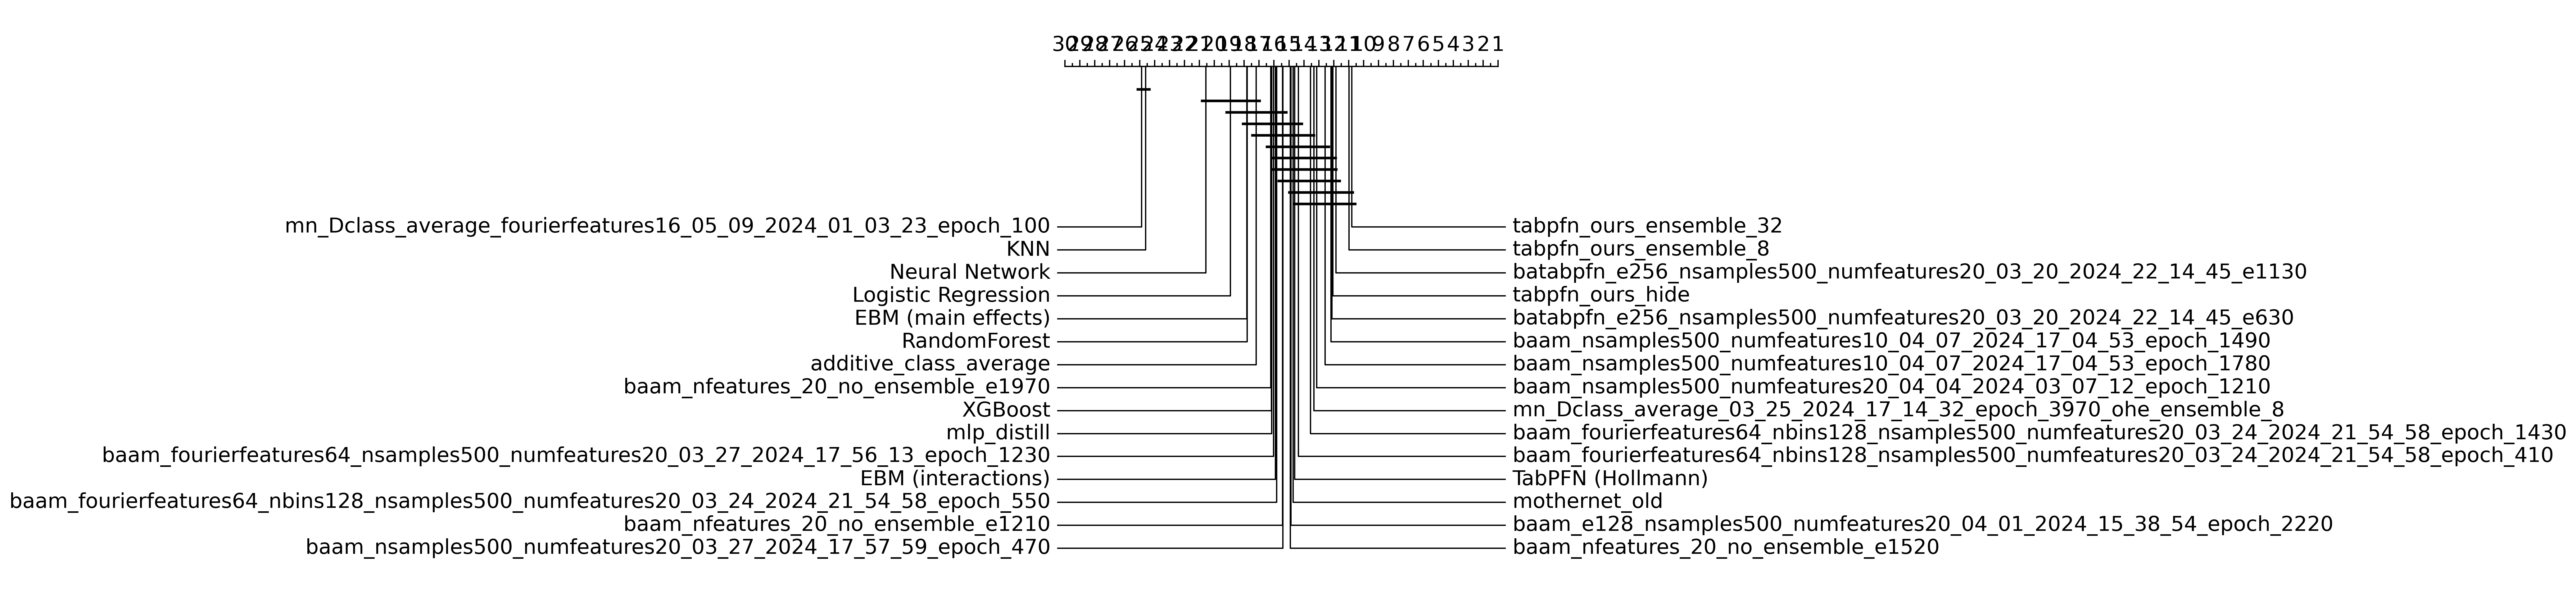

In [281]:
plt.figure(figsize=(8, 8), dpi=300)
combined_best_valid = get_best_over_time(valid_results)
pivoted_for_cd = combined_best_valid.pivot(index="dataset", columns="model", values="mean_metric")
_ = cd_evaluation(pivoted_for_cd, maximize_metric=True, ax=plt.gca())
plt.savefig("../figures/cd_diagram_validation.pdf", bbox_inches="tight")

In [282]:
combined_best_valid.groupby("model").mean_metric.mean().sort_values()

model
mn_Dclass_average_fourierfeatures16_05_09_2024_01_03_23_epoch_100                           0.769800
KNN                                                                                         0.792672
Logistic Regression                                                                         0.810312
Neural Network                                                                              0.814622
baam_fourierfeatures64_nsamples500_numfeatures20_03_27_2024_17_56_13_epoch_1230             0.822347
additive_class_average                                                                      0.823193
baam_nfeatures_20_no_ensemble_e1970                                                         0.824194
EBM (main effects)                                                                          0.824505
baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_550     0.825521
baam_nsamples500_numfeatures20_03_27_2024_17_57_59_epoch_470                         

In [283]:
if test_result_file:
    plt.figure(figsize=(8, 3), dpi=300)
    combined_best_test = get_best_over_time(test_results)
    pivoted_for_cd = combined_best_test.pivot(index="dataset", columns="model", values="mean_metric")
    _ = cd_evaluation(pivoted_for_cd, maximize_metric=True, ax=plt.gca())
    plt.savefig("../figures/cd_diagram_test.pdf", bbox_inches="tight")

In [284]:
def compare_splits(results):
    compare_splits_over_time = results.groupby(["model", "split", "max_time"])[['mean_metric', 'fit_time']].mean().reset_index()
    compare_splits_varies = compare_splits_over_time[compare_splits_over_time.model.isin(varies_over_time)]
    compare_splits_fixed = compare_splits_over_time[~compare_splits_over_time.model.isin(varies_over_time)]
    compare_splits_varies_last = compare_splits_varies[compare_splits_varies.max_time == compare_splits_varies.max_time.max()]
    return compare_splits_over_time, pd.concat([compare_splits_fixed, compare_splits_varies_last])

In [285]:
compare_splits_over_time_valid, compare_splits_valid = compare_splits(valid_results)
if test_result_file:
    compare_splits_over_time_test, compare_splits_test = compare_splits(test_results)

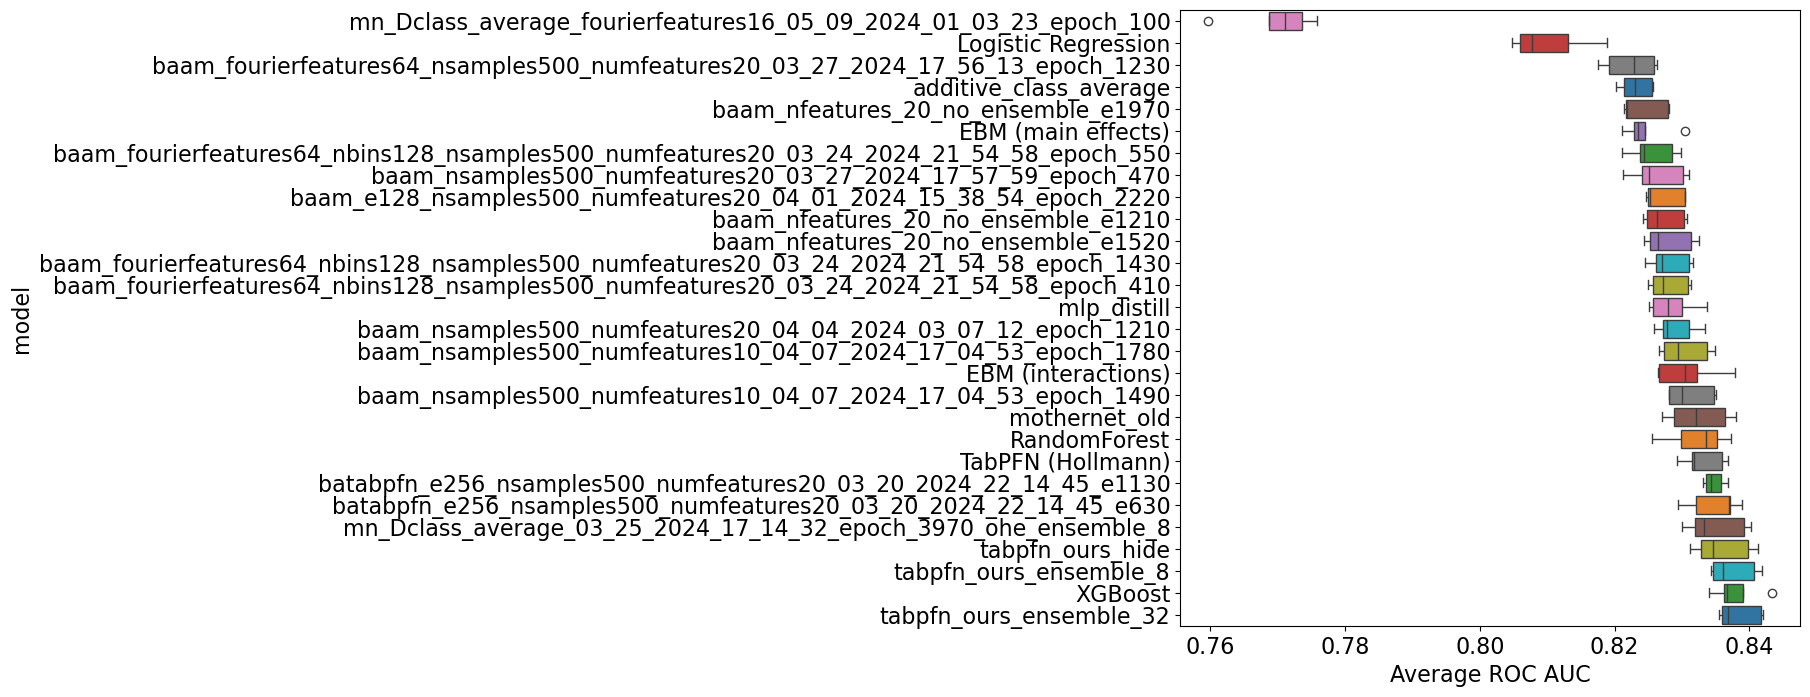

In [286]:
plt.figure(figsize=(8, 8))
compare_splits_valid = compare_splits_valid[~compare_splits_valid.model.isin(["KNN", "Neural Network"])]
order = compare_splits_valid.groupby("model").mean("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_valid, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
#sns.boxplot(data=compare_splits_valid, y="model", x="mean_metric",order=order, ax=plt.gca(), hue="model")

plt.xlabel("Average ROC AUC")
plt.savefig("../figures/mean_roc_auc_validation.pdf", dpi=300, bbox_inches="tight")

In [287]:
if test_result_file:
    plt.figure(figsize=(8, 6))
    order = compare_splits_test.groupby("model").median("mean_metric").sort_values("mean_metric").index
    sns.boxplot(data=compare_splits_test, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
    plt.xlabel("Average ROC AUC")
    plt.savefig("../figures/mean_roc_auc_test.pdf", dpi=300, bbox_inches="tight")

In [288]:
def normalize_metric(results):
    dataset_min_max = results.groupby("dataset").mean_metric.agg(["min", "max"])
    results_normalized = results.merge(dataset_min_max, on="dataset")
    results_normalized['mean_metric'] = (results_normalized['mean_metric'] - results_normalized['min']) / (results_normalized['max'] - results_normalized['min'])
    return results_normalized

In [289]:
compare_splits_over_time_valid_normalized, compare_splits_valid_normalized = compare_splits(normalize_metric(valid_results))
if test_result_file:
    compare_splits_over_time_test_normalized, compare_splits_test_normalized = compare_splits(normalize_metric(test_results))

In [290]:
if test_result_file:
    plt.figure(figsize=(8, 6))
    order = compare_splits_test_normalized.groupby("model").median("mean_metric").sort_values("mean_metric").index
    sns.boxplot(data=compare_splits_test_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
    plt.xlabel("Average ROC AUC (normalized)", loc="right")
    plt.savefig("../figures/mean_roc_auc_test_normalized.pdf", dpi=300, bbox_inches="tight")
    pd.set_option("display.float_format", lambda x: f"{x:.2f}")
    table = compare_splits_test_normalized.groupby("model").median()[['mean_metric', 'fit_time']].sort_values("mean_metric")
    print(table.to_markdown(floatfmt=".2f"))

In [291]:
# table.drop(index=["mothernet_old", "mlp_distill", 'KNN']).rename({'mn_Dclass_average_03_25_2024_17_14_32_epoch_2910_ohe_ensemble_8': 'MotherNet'})

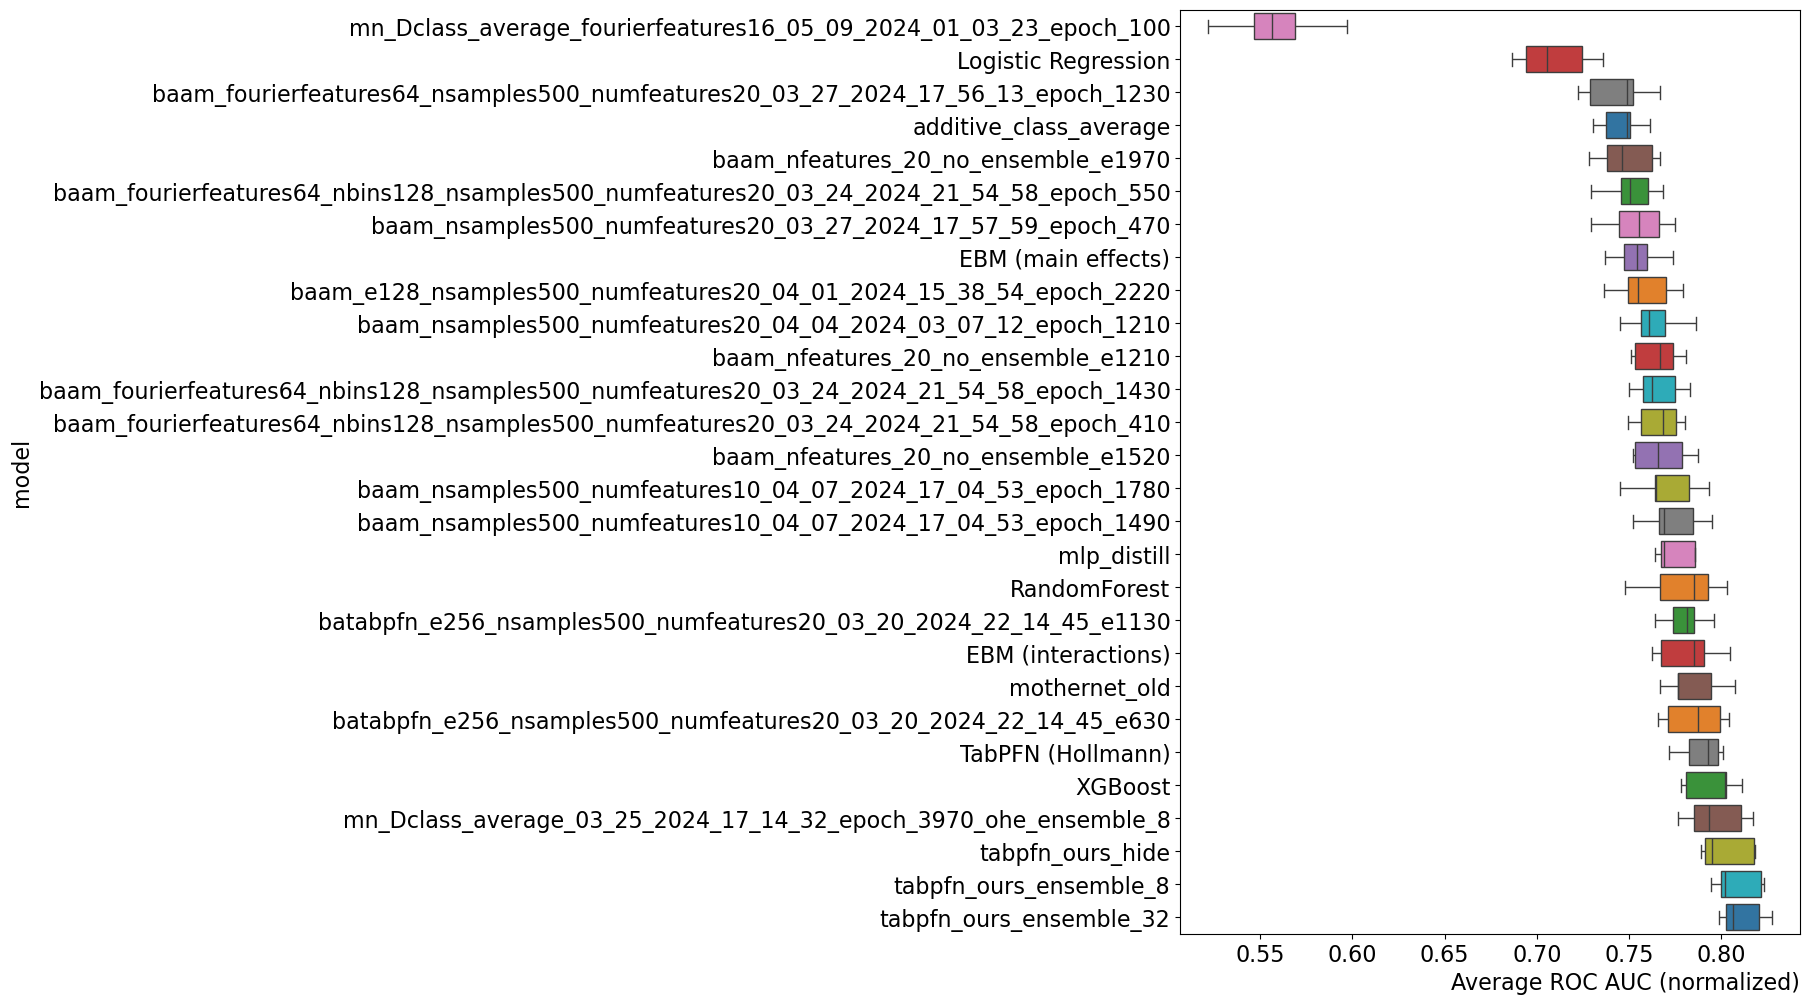

In [292]:
plt.figure(figsize=(8, 12))
compare_splits_valid_normalized = compare_splits_valid_normalized[~compare_splits_valid_normalized.model.isin(["KNN", "Neural Network"])]
order = compare_splits_valid_normalized.groupby("model").mean("mean_metric").sort_values("mean_metric").index
sns.boxplot(data=compare_splits_valid_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), palette=color_mapping)
#sns.boxplot(data=compare_splits_valid_normalized, y="model", x="mean_metric", order=order, ax=plt.gca(), hue='model')

plt.xlabel("Average ROC AUC (normalized)", loc="right")
plt.savefig("../figures/mean_roc_auc_valid_normalized.pdf", dpi=300, bbox_inches="tight")

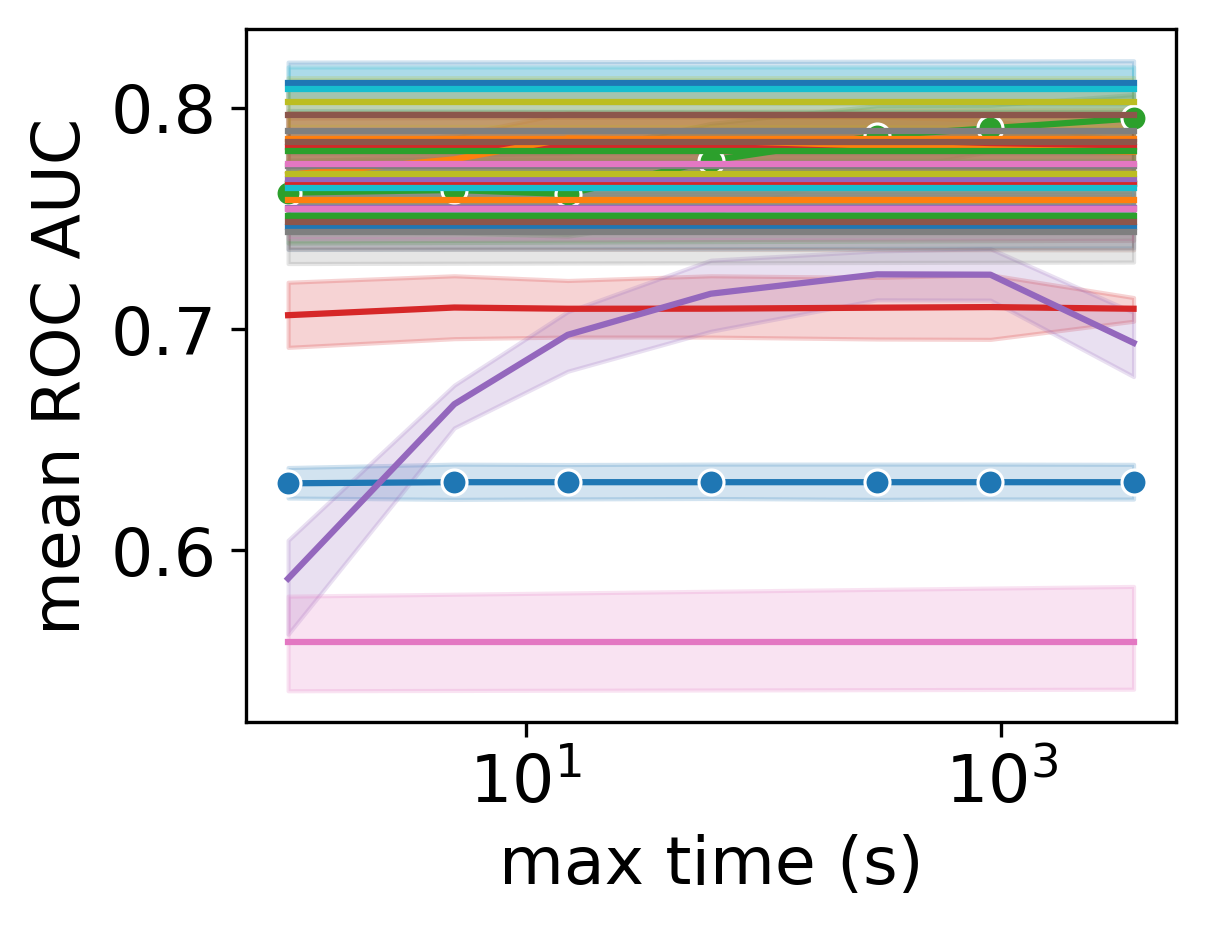

In [293]:
plt.figure(figsize=(4, 3), dpi=300)

compare_splits_varies = compare_splits_over_time_valid_normalized[compare_splits_over_time_valid_normalized.model.isin(varies_over_time)]
compare_splits_fixed = compare_splits_over_time_valid_normalized[~compare_splits_over_time_valid_normalized.model.isin(varies_over_time)]


ax = sns.lineplot(data=compare_splits_varies, x="max_time", y="mean_metric", hue="model",  marker="o", palette=color_mapping)

compare_splits_fixed_dummy = compare_splits_over_time_valid_normalized.copy()
compare_splits_fixed_dummy['max_time'] = compare_splits_varies.max_time.max()
sns.lineplot(data=pd.concat([compare_splits_fixed, compare_splits_fixed_dummy]),
              x="max_time", y="mean_metric", hue="model", ax=ax, palette=color_mapping)
plt.xscale("log")
#legend = plt.legend(loc=(1.1 , .3))
legend = ax.get_legend()
legend.remove()
#ax.set_ylim(0.85, 0.90)
ax.set_ylabel("mean ROC AUC")
ax.set_xlabel("max time (s)")
plt.savefig("../figures/mean_auc_over_time_valid_normalized.pdf", bbox_inches="tight")

In [294]:
per_dataset = combined_best_valid.pivot(index="dataset", columns="model", values="mean_metric")

In [275]:
per_dataset.columns

Index(['EBM (interactions)', 'EBM (main effects)', 'KNN',
       'Logistic Regression', 'Neural Network', 'RandomForest',
       'TabPFN (Hollmann)', 'XGBoost', 'additive_class_average',
       'baam_e128_nsamples500_numfeatures20_04_01_2024_15_38_54_epoch_2220',
       'baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430',
       'baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_410',
       'baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_550',
       'baam_fourierfeatures64_nsamples500_numfeatures20_03_27_2024_17_56_13_epoch_1230',
       'baam_nfeatures_20_no_ensemble_e1210',
       'baam_nfeatures_20_no_ensemble_e1520',
       'baam_nfeatures_20_no_ensemble_e1970',
       'baam_nfeatures_20_no_ensemble_e1970_new_data_loading2',
       'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490',
       'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1780',
     

In [252]:
compare = per_dataset.loc[:, ['tabpfn_ours_ensemble_32',  'EBM (main effects)', 'mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8', 'XGBoost',  'batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130', 'baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430',  'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490', 'baam_nfeatures_20_no_ensemble_e1520', ]]

In [253]:
compare

model,tabpfn_ours_ensemble_32,EBM (main effects),mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8,XGBoost,batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130,baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430,baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490,baam_nfeatures_20_no_ensemble_e1520
dataset,,,,,,,,
Australian,0.929619,0.925615,0.924606,0.929038,0.931555,0.927388,0.929341,0.928642
CPMP-2015-runtime-classification,0.715614,0.723172,0.714919,0.711893,0.715165,0.714114,0.715226,0.720456
CastMetal1,0.770802,0.680774,0.747674,0.733973,0.750613,0.768497,0.750323,0.740203
CostaMadre1,0.778185,0.680787,0.763974,0.736829,0.768548,0.754012,0.759163,0.750643
DiabeticMellitus,0.996342,0.992011,0.994790,0.995029,0.788639,0.994995,0.997342,0.997830
...,...,...,...,...,...,...,...,...
water-treatment,0.988836,0.988702,0.983163,0.994902,0.912525,0.975065,0.971283,0.995184
wholesale-customers,0.958821,0.955381,0.956053,0.952733,0.961478,0.960168,0.959680,0.958853
wine,0.999634,0.999484,0.999628,0.999448,0.999619,0.998906,0.999325,0.998770


In [254]:
compare['diff'] = compare['EBM (main effects)'] - compare['baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430']

In [255]:
compare.sort_values("diff")

model,tabpfn_ours_ensemble_32,EBM (main effects),mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8,XGBoost,batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130,baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430,baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490,baam_nfeatures_20_no_ensemble_e1520,diff
dataset,,,,,,,,,
prnn_crabs,0.999840,0.863685,0.999680,0.973203,1.000000,1.000000,0.999759,0.999438,-0.136315
CastMetal1,0.770802,0.680774,0.747674,0.733973,0.750613,0.768497,0.750323,0.740203,-0.087723
CostaMadre1,0.778185,0.680787,0.763974,0.736829,0.768548,0.754012,0.759163,0.750643,-0.073226
lungcancer_GSE31210,0.840035,0.782983,0.835784,0.786734,0.830898,0.853708,0.826699,0.825985,-0.070724
analcatdata_germangss,0.763179,0.704120,0.740722,0.709482,0.783441,0.757177,0.767031,0.752160,-0.053057
...,...,...,...,...,...,...,...,...,...
heart-long-beach,0.611448,0.638492,0.620586,0.616185,0.621784,0.595338,0.604850,0.620606,0.043155
kdd_el_nino-small,0.978704,0.987236,0.957284,0.991715,0.974599,0.922624,0.966296,0.978504,0.064613
profb,0.643791,0.639734,0.679831,0.633997,0.642982,0.572329,0.658488,0.642901,0.067405


In [131]:
compare['diff'] = compare['EBM (main effects)'] - compare['baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430']

In [132]:
compare.sort_values("diff")

model,tabpfn_ours_ensemble_32,EBM (main effects),mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8,XGBoost,batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130,baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430,baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490,baam_nfeatures_20_no_ensemble_e1520,diff
dataset,,,,,,,,,
prnn_crabs,0.999840,0.863685,0.999680,0.973203,1.000000,1.000000,0.999759,0.999438,-0.136315
CastMetal1,0.770802,0.680774,0.747674,0.733973,0.750613,0.768497,0.750323,0.740203,-0.087723
CostaMadre1,0.778185,0.680787,0.763974,0.736829,0.768548,0.754012,0.759163,0.750643,-0.073226
lungcancer_GSE31210,0.840035,0.782983,0.835784,0.786734,0.830898,0.853708,0.826699,0.825985,-0.070724
analcatdata_germangss,0.763179,0.704120,0.740722,0.709482,0.783441,0.757177,0.767031,0.752160,-0.053057
...,...,...,...,...,...,...,...,...,...
heart-long-beach,0.611448,0.638492,0.620586,0.616185,0.621784,0.595338,0.604850,0.620606,0.043155
kdd_el_nino-small,0.978704,0.987236,0.957284,0.991715,0.974599,0.922624,0.966296,0.978504,0.064613
profb,0.643791,0.639734,0.679831,0.633997,0.642982,0.572329,0.658488,0.642901,0.067405


In [133]:
compare.columns

Index(['tabpfn_ours_ensemble_32', 'EBM (main effects)',
       'mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8',
       'XGBoost',
       'batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130',
       'baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430',
       'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490',
       'baam_nfeatures_20_no_ensemble_e1520', 'diff'],
      dtype='object', name='model')

In [155]:
compare2 = compare[['tabpfn_ours_ensemble_32', 'mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8' , 'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490']].rename(columns={'mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8': 'mn', 'baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490': 'baam', 'tabpfn_ours_ensemble_32': 'tabpfn'})

In [156]:
from mothernet.datasets import load_openml_list, open_cc_valid_dids, open_cc_dids

cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)


Number of datasets: 149


/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/openml/datasets/dataset.py:851: RuntimeWarning: invalid value encountered in cast
  y = y.astype(target_dtype) if isinstance(y, np.ndarray) else y


In [157]:
compare2

model,tabpfn,mn,baam
dataset,,,
Australian,0.929619,0.924606,0.929341
CPMP-2015-runtime-classification,0.715614,0.714919,0.715226
CastMetal1,0.770802,0.747674,0.750323
CostaMadre1,0.778185,0.763974,0.759163
DiabeticMellitus,0.996342,0.994790,0.997342
...,...,...,...
water-treatment,0.988836,0.983163,0.971283
wholesale-customers,0.958821,0.956053,0.959680
wine,0.999634,0.999628,0.999325


In [161]:
res_long = compare2.reset_index().melt(id_vars="dataset")

In [162]:

cc_valid_datasets_multiclass_df.merge(res_long, right_on="dataset", left_on="name")

,did,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,dataset,model,value
0,13,breast-cancer,1,1,active,ARFF,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0,breast-cancer,tabpfn,0.712373
1,13,breast-cancer,1,1,active,ARFF,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0,breast-cancer,mn,0.715071
2,13,breast-cancer,1,1,active,ARFF,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0,breast-cancer,baam,0.712627
3,25,colic,1,1,active,ARFF,232.0,63.0,136.0,2.0,27.0,368.0,361.0,1927.0,7.0,20.0,colic,tabpfn,0.864397
4,25,colic,1,1,active,ARFF,232.0,63.0,136.0,2.0,27.0,368.0,361.0,1927.0,7.0,20.0,colic,mn,0.872191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,42585,penguins,1,13013,active,ARFF,152.0,NaN,68.0,3.0,7.0,344.0,10.0,18.0,4.0,3.0,penguins,mn,0.999813
443,42585,penguins,1,13013,active,ARFF,152.0,NaN,68.0,3.0,7.0,344.0,10.0,18.0,4.0,3.0,penguins,baam,0.999400
444,42638,titanic,9,14765,active,ARFF,549.0,NaN,342.0,2.0,8.0,891.0,689.0,689.0,3.0,5.0,titanic,tabpfn,0.876146
445,42638,titanic,9,14765,active,ARFF,549.0,NaN,342.0,2.0,8.0,891.0,689.0,689.0,3.0,5.0,titanic,mn,0.871897


In [165]:
df = cc_valid_datasets_multiclass_df.merge(res_long, right_on="dataset", left_on="name").drop(columns=['did', 'name', 'version', 'status', 'uploader', 'format', 'dataset'])

In [166]:
df

,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,model,value
0,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0,tabpfn,0.712373
1,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0,mn,0.715071
2,201.0,11.0,85.0,2.0,10.0,286.0,9.0,9.0,0.0,10.0,baam,0.712627
3,232.0,63.0,136.0,2.0,27.0,368.0,361.0,1927.0,7.0,20.0,tabpfn,0.864397
4,232.0,63.0,136.0,2.0,27.0,368.0,361.0,1927.0,7.0,20.0,mn,0.872191
...,...,...,...,...,...,...,...,...,...,...,...,...
442,152.0,NaN,68.0,3.0,7.0,344.0,10.0,18.0,4.0,3.0,mn,0.999813
443,152.0,NaN,68.0,3.0,7.0,344.0,10.0,18.0,4.0,3.0,baam,0.999400
444,549.0,NaN,342.0,2.0,8.0,891.0,689.0,689.0,3.0,5.0,tabpfn,0.876146
445,549.0,NaN,342.0,2.0,8.0,891.0,689.0,689.0,3.0,5.0,mn,0.871897


/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/dabl/preprocessing.py:172: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(series[:10])
/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/dabl/plot/supervised.py:107: UserWarning: Not plotting highly correlated (0.9989404778540496) feature NumberOfInstancesWithMissingValues. Set prune_correlations_threshold=0 to keep.
  warn(f"Not plotting highly correlated ({corr.max()})"


Target looks like regression


[<AxesSubplot: title={'center': 'Target distribution'}, xlabel='value', ylabel='frequency'>,
 array([[<AxesSubplot: title={'center': 'F=-1.87E-01'}, xlabel='MajorityClassSize', ylabel='value'>,
         <AxesSubplot: title={'center': 'F=-1.22E-01'}, xlabel='NumberOfInstances'>,
         <AxesSubplot: title={'center': 'F=9.88E-02'}, xlabel='MaxNominalAttDistinctValues'>,
         <AxesSubplot: title={'center': 'F=-7.92E-02'}, xlabel='MinorityClassSize'>],
        [<AxesSubplot: title={'center': 'F=4.53E-02'}, xlabel='NumberOfMissingValues (jittered)', ylabel='value'>,
         <AxesSubplot: title={'center': 'F=3.35E-02'}, xlabel='NumberOfNumericFeatures (jittered)'>,
         <AxesSubplot: title={'center': 'F=-9.05E-03'}, xlabel='NumberOfFeatures (jittered)'>,
         <AxesSubplot: title={'center': 'F=-6.37E-03'}, xlabel='NumberOfSymbolicFeatures (jittered)'>]],
       dtype=object),
 array([[<AxesSubplot: title={'center': 'F=2.51E-01'}, xlabel='value', ylabel='NumberOfClasses'>,
     

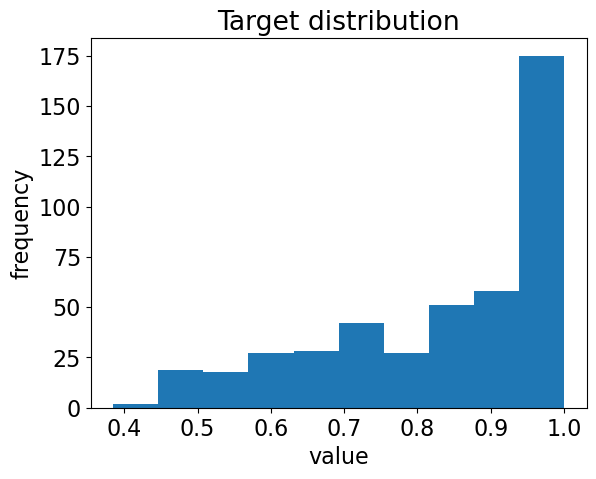

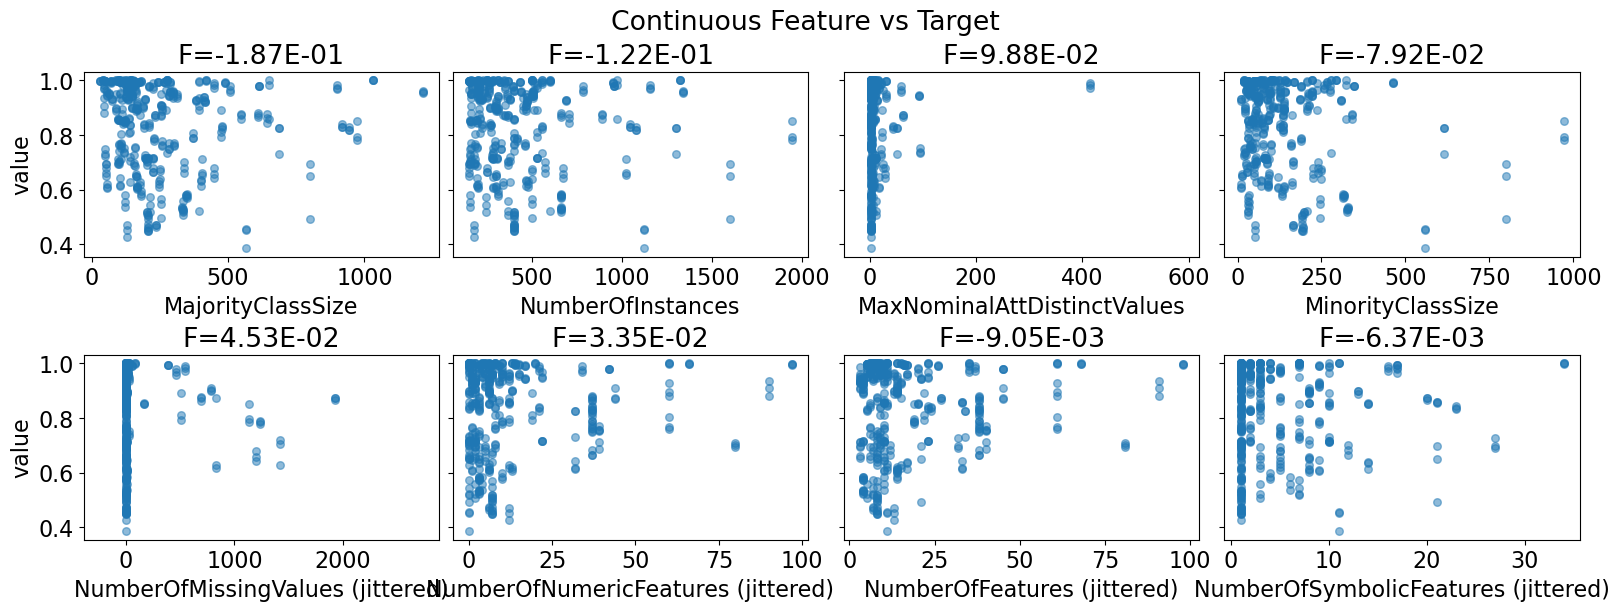

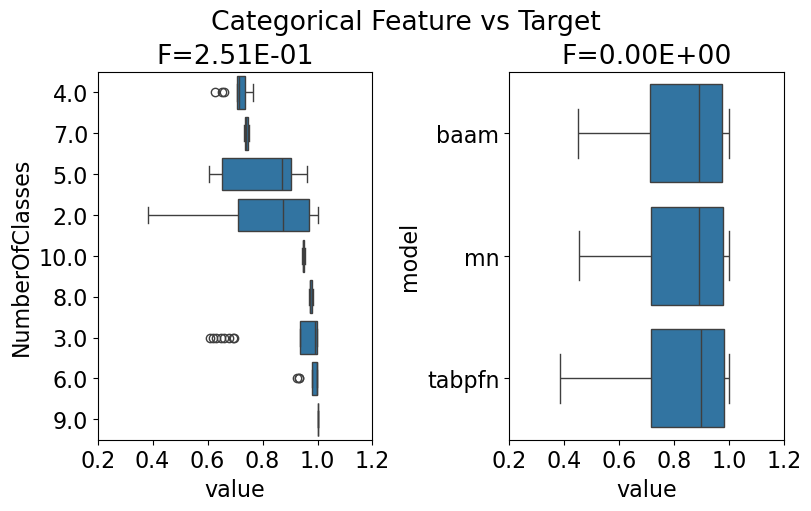

In [168]:
import dabl
dabl.plot(df, target_col="value")

<AxesSubplot: xlabel='value', ylabel='MajorityClassSize'>

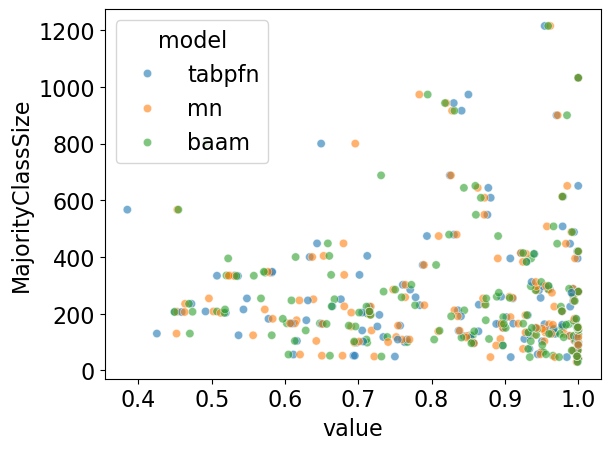

In [173]:
import seaborn as sns
sns.scatterplot(data=df, x='value', y='MajorityClassSize', hue='model', alpha=.6)

<AxesSubplot: xlabel='value', ylabel='NumberOfInstances'>

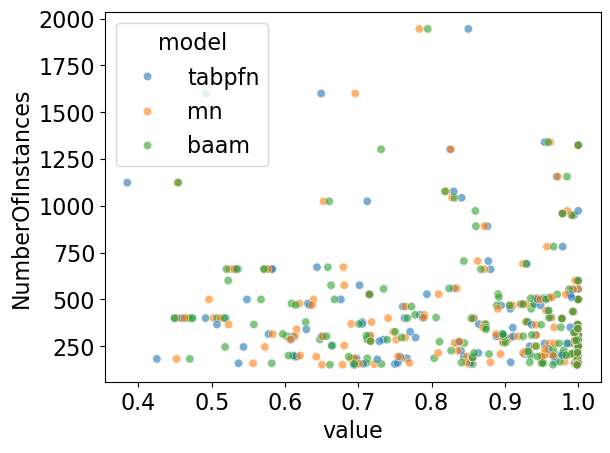

In [174]:
sns.scatterplot(data=df, x='value', y='NumberOfInstances', hue='model', alpha=.6)

In [175]:
df.columns

Index(['MajorityClassSize', 'MaxNominalAttDistinctValues', 'MinorityClassSize',
       'NumberOfClasses', 'NumberOfFeatures', 'NumberOfInstances',
       'NumberOfInstancesWithMissingValues', 'NumberOfMissingValues',
       'NumberOfNumericFeatures', 'NumberOfSymbolicFeatures', 'model',
       'value'],
      dtype='object')

<AxesSubplot: xlabel='value', ylabel='MaxNominalAttDistinctValues'>

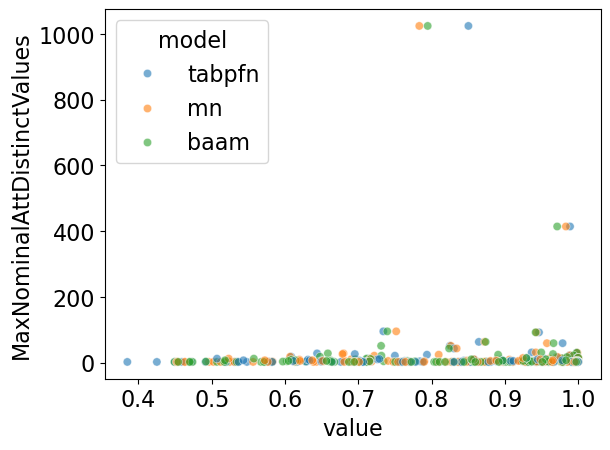

In [176]:
sns.scatterplot(data=df, x='value', y='MaxNominalAttDistinctValues', hue='model', alpha=.6)

<AxesSubplot: xlabel='value', ylabel='NumberOfInstancesWithMissingValues'>

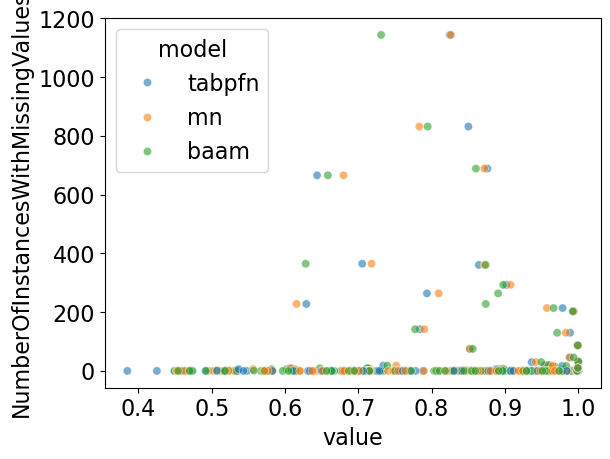

In [177]:
sns.scatterplot(data=df, x='value', y='NumberOfInstancesWithMissingValues', hue='model', alpha=.6)

<AxesSubplot: xlabel='value', ylabel='NumberOfSymbolicFeatures'>

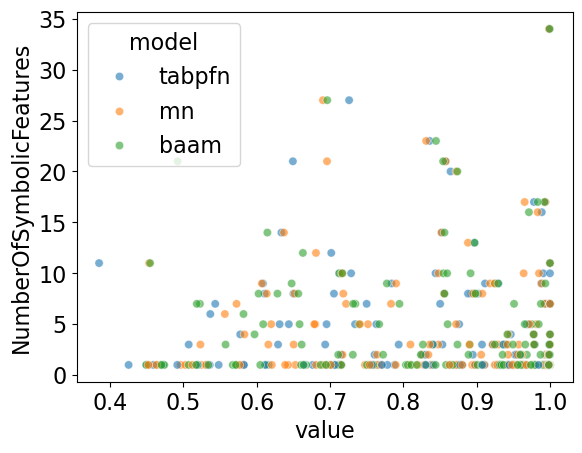

In [178]:
sns.scatterplot(data=df, x='value', y='NumberOfSymbolicFeatures', hue='model', alpha=.6)

<AxesSubplot: xlabel='tabpfn', ylabel='mn'>

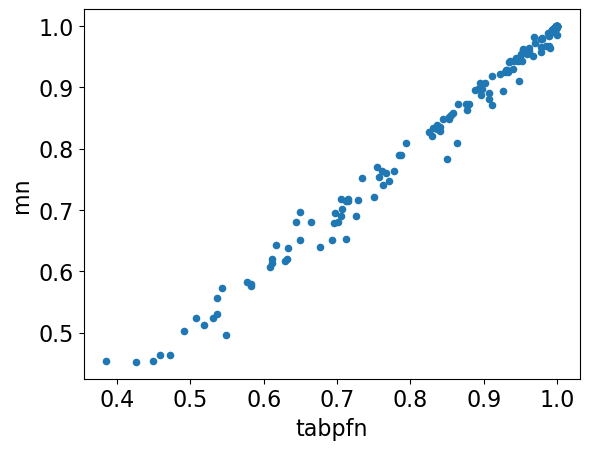

In [181]:
compare2.plot(x="tabpfn", y="mn", kind="scatter")

<AxesSubplot: xlabel='tabpfn', ylabel='baam'>

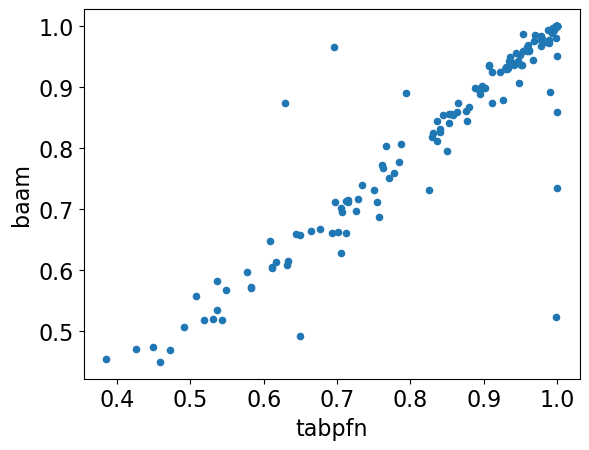

In [182]:
compare2.plot(x="tabpfn", y="baam", kind="scatter")

In [183]:
compare

model,tabpfn_ours_ensemble_32,EBM (main effects),mn_Dclass_average_03_25_2024_17_14_32_epoch_3970_ohe_ensemble_8,XGBoost,batabpfn_e256_nsamples500_numfeatures20_03_20_2024_22_14_45_e1130,baam_fourierfeatures64_nbins128_nsamples500_numfeatures20_03_24_2024_21_54_58_epoch_1430,baam_nsamples500_numfeatures10_04_07_2024_17_04_53_epoch_1490,baam_nfeatures_20_no_ensemble_e1520,diff
dataset,,,,,,,,,
Australian,0.929619,0.925615,0.924606,0.929038,0.931555,0.927388,0.929341,0.928642,-0.001773
CPMP-2015-runtime-classification,0.715614,0.723172,0.714919,0.711893,0.715165,0.714114,0.715226,0.720456,0.009058
CastMetal1,0.770802,0.680774,0.747674,0.733973,0.750613,0.768497,0.750323,0.740203,-0.087723
CostaMadre1,0.778185,0.680787,0.763974,0.736829,0.768548,0.754012,0.759163,0.750643,-0.073226
DiabeticMellitus,0.996342,0.992011,0.994790,0.995029,0.788639,0.994995,0.997342,0.997830,-0.002984
...,...,...,...,...,...,...,...,...,...
water-treatment,0.988836,0.988702,0.983163,0.994902,0.912525,0.975065,0.971283,0.995184,0.013637
wholesale-customers,0.958821,0.955381,0.956053,0.952733,0.961478,0.960168,0.959680,0.958853,-0.004787
wine,0.999634,0.999484,0.999628,0.999448,0.999619,0.998906,0.999325,0.998770,0.000578


/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


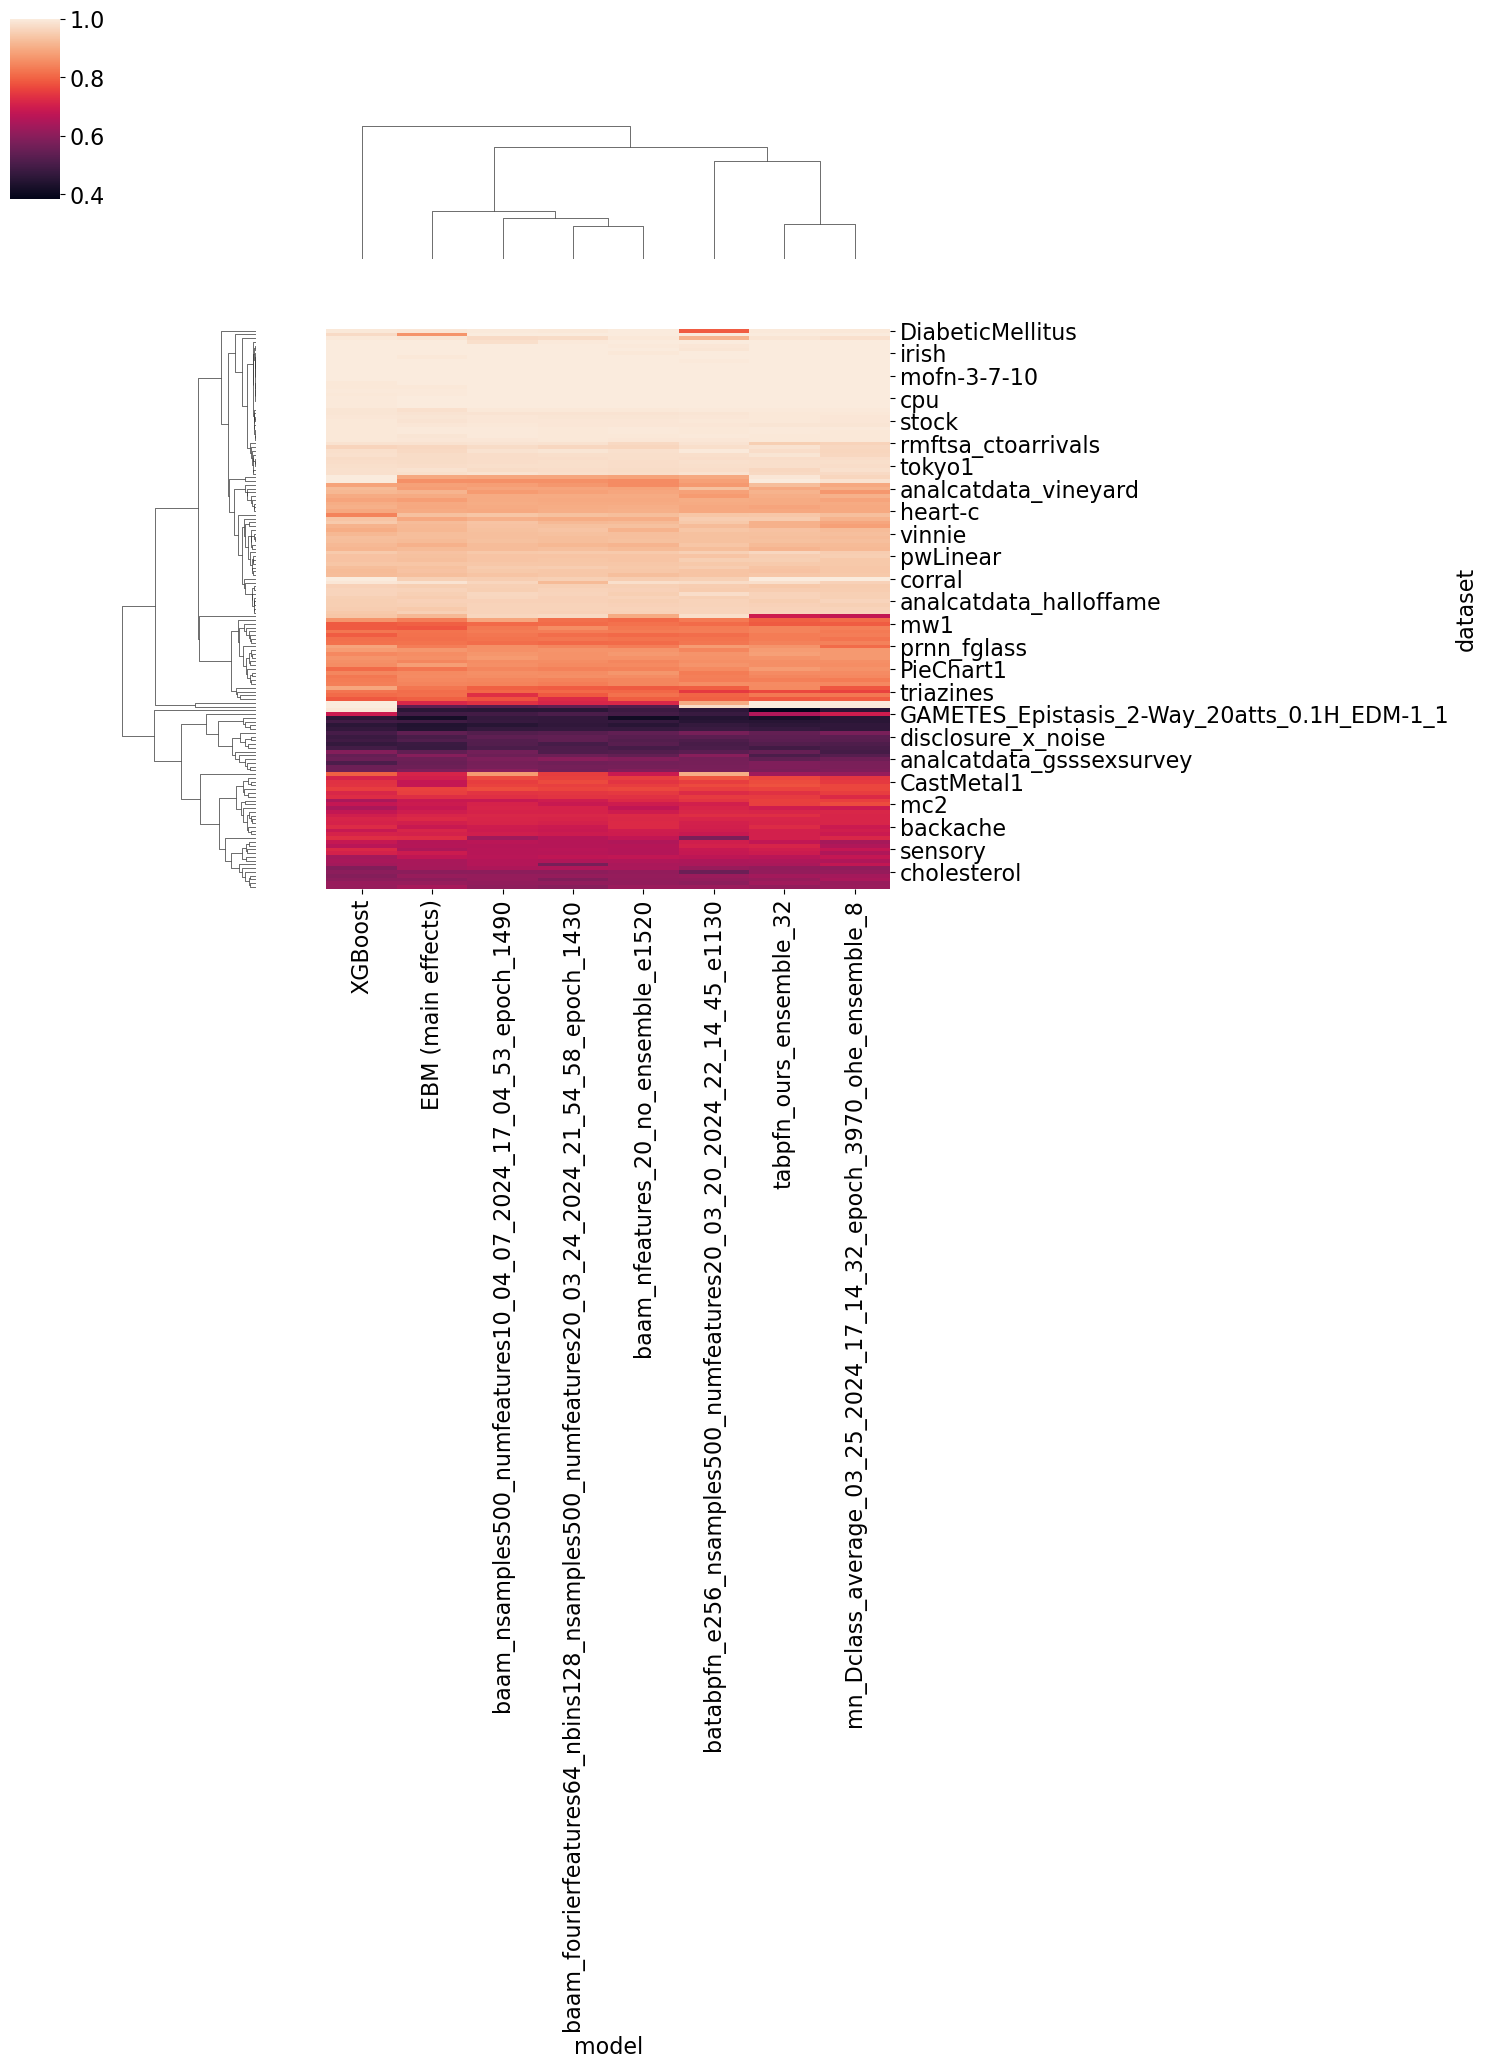

In [186]:
sns.clustermap(compare.drop(columns="diff"))

In [219]:
bla = compare.drop(columns="diff")
bla = bla[bla.index != 'mofn-3-7-10']

In [220]:
grr = bla_normed.isna().T.any()

In [221]:
bla.index

Index(['Australian', 'CPMP-2015-runtime-classification', 'CastMetal1',
       'CostaMadre1', 'DiabeticMellitus',
       'GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1', 'KnuggetChase3',
       'LED-display-domain-7digit', 'MegaWatt1', 'PieChart1',
       ...
       'user-knowledge', 'vertebra-column', 'vinnie', 'visualizing_galaxy',
       'vote', 'water-treatment', 'wholesale-customers', 'wine', 'wisconsin',
       'xd6'],
      dtype='object', name='dataset', length=148)

In [223]:
grr = bla_normed.isna().T.any()
grr[grr]

dataset
mofn-3-7-10    True
dtype: bool

In [228]:
bla_normed = ((bla.T - bla.mean(axis=1))/bla.std(axis=1)).T
bla_normed2 = (bla.T - bla.mean(axis=1)).T

/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


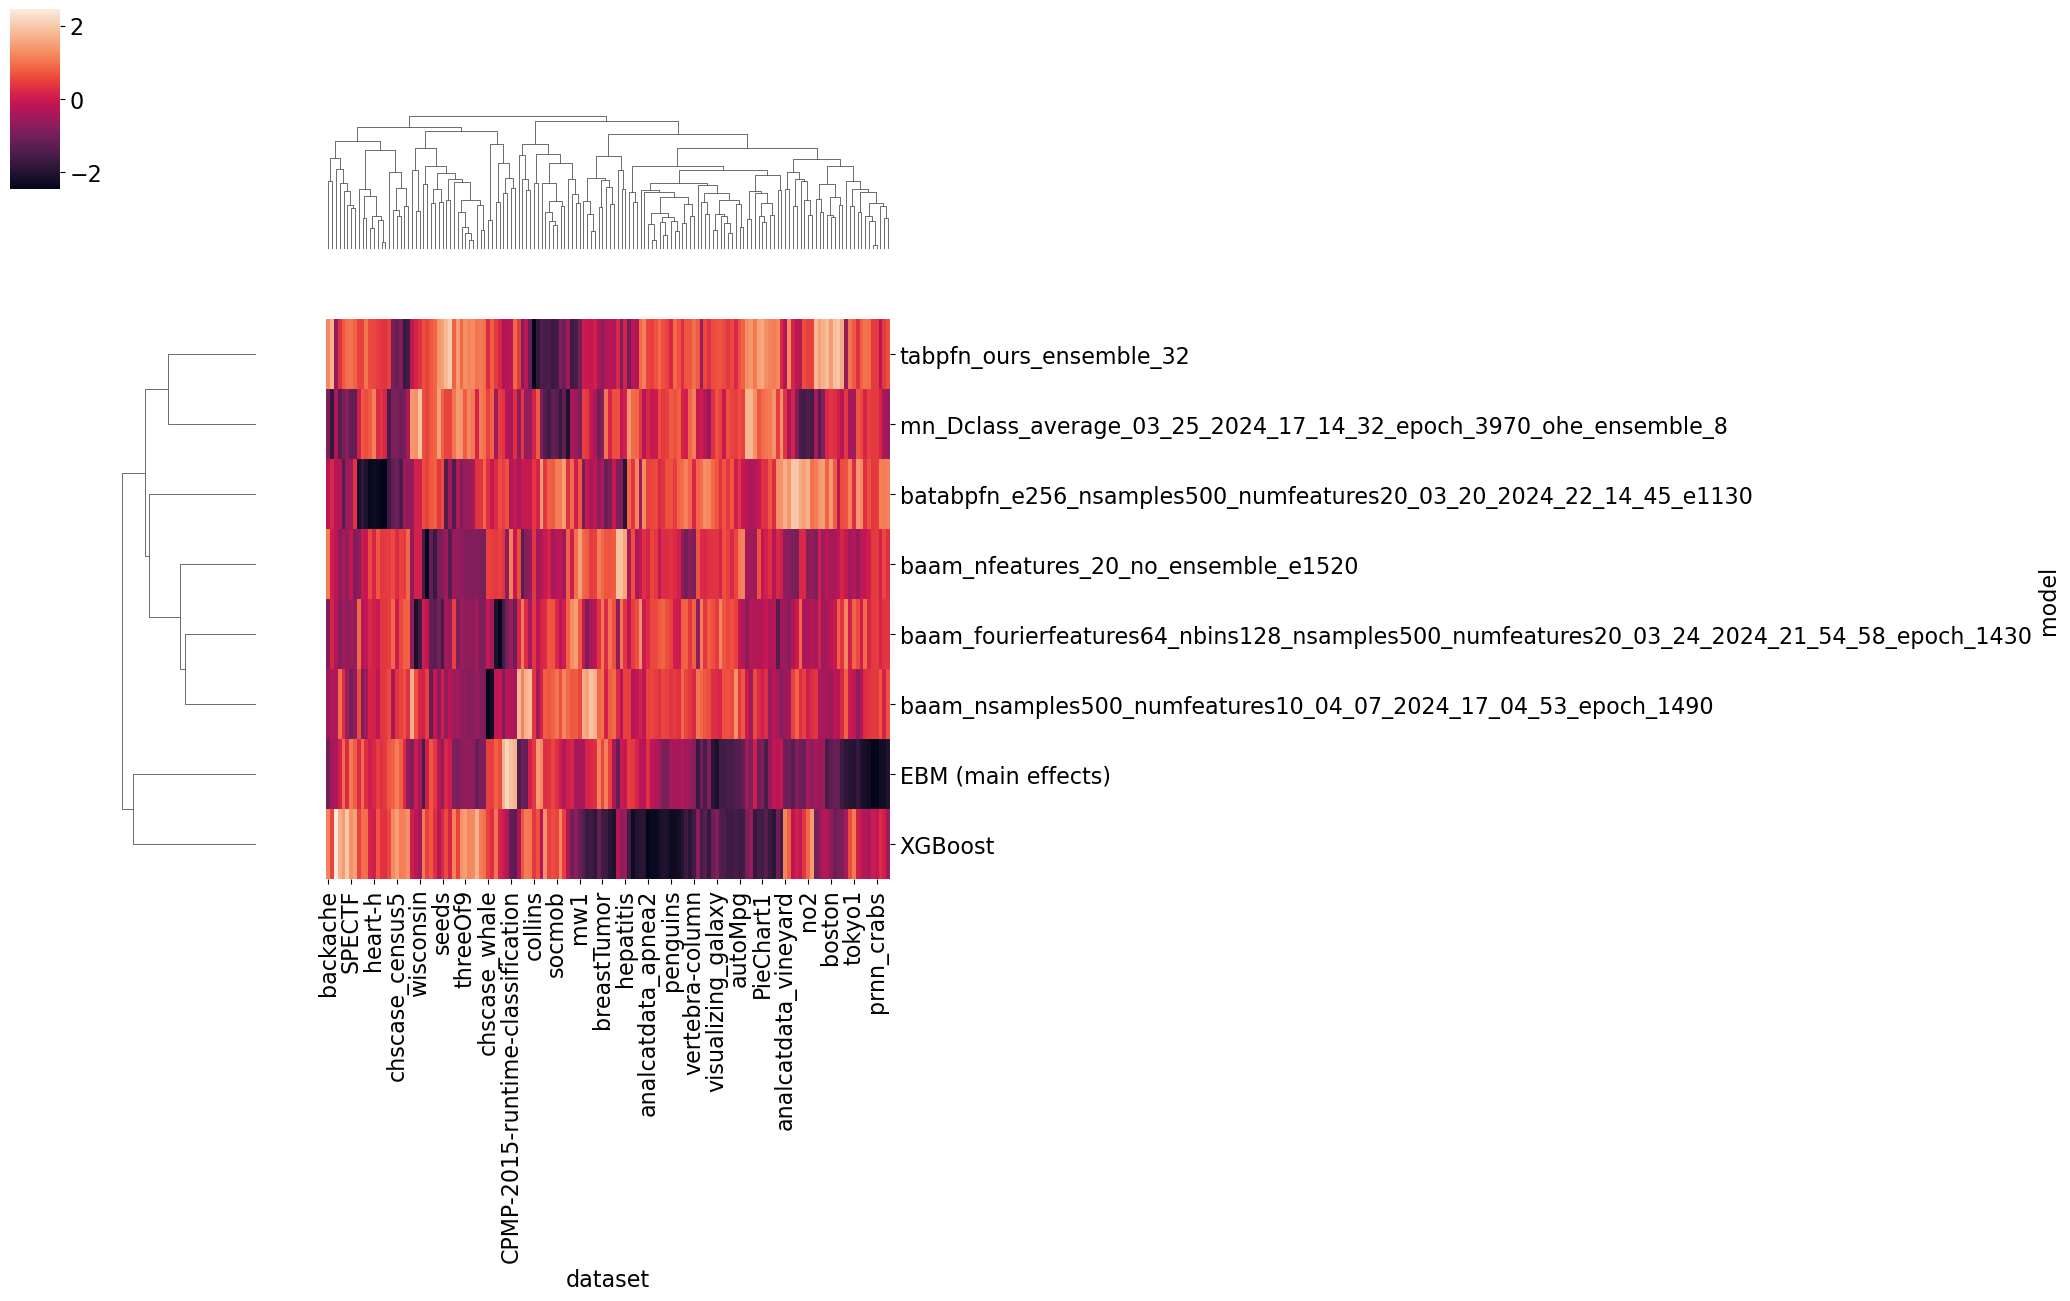

In [226]:
sns.clustermap(bla_normed.T)

/anaconda/envs/tabpfn_testing_environment/lib/python3.11/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


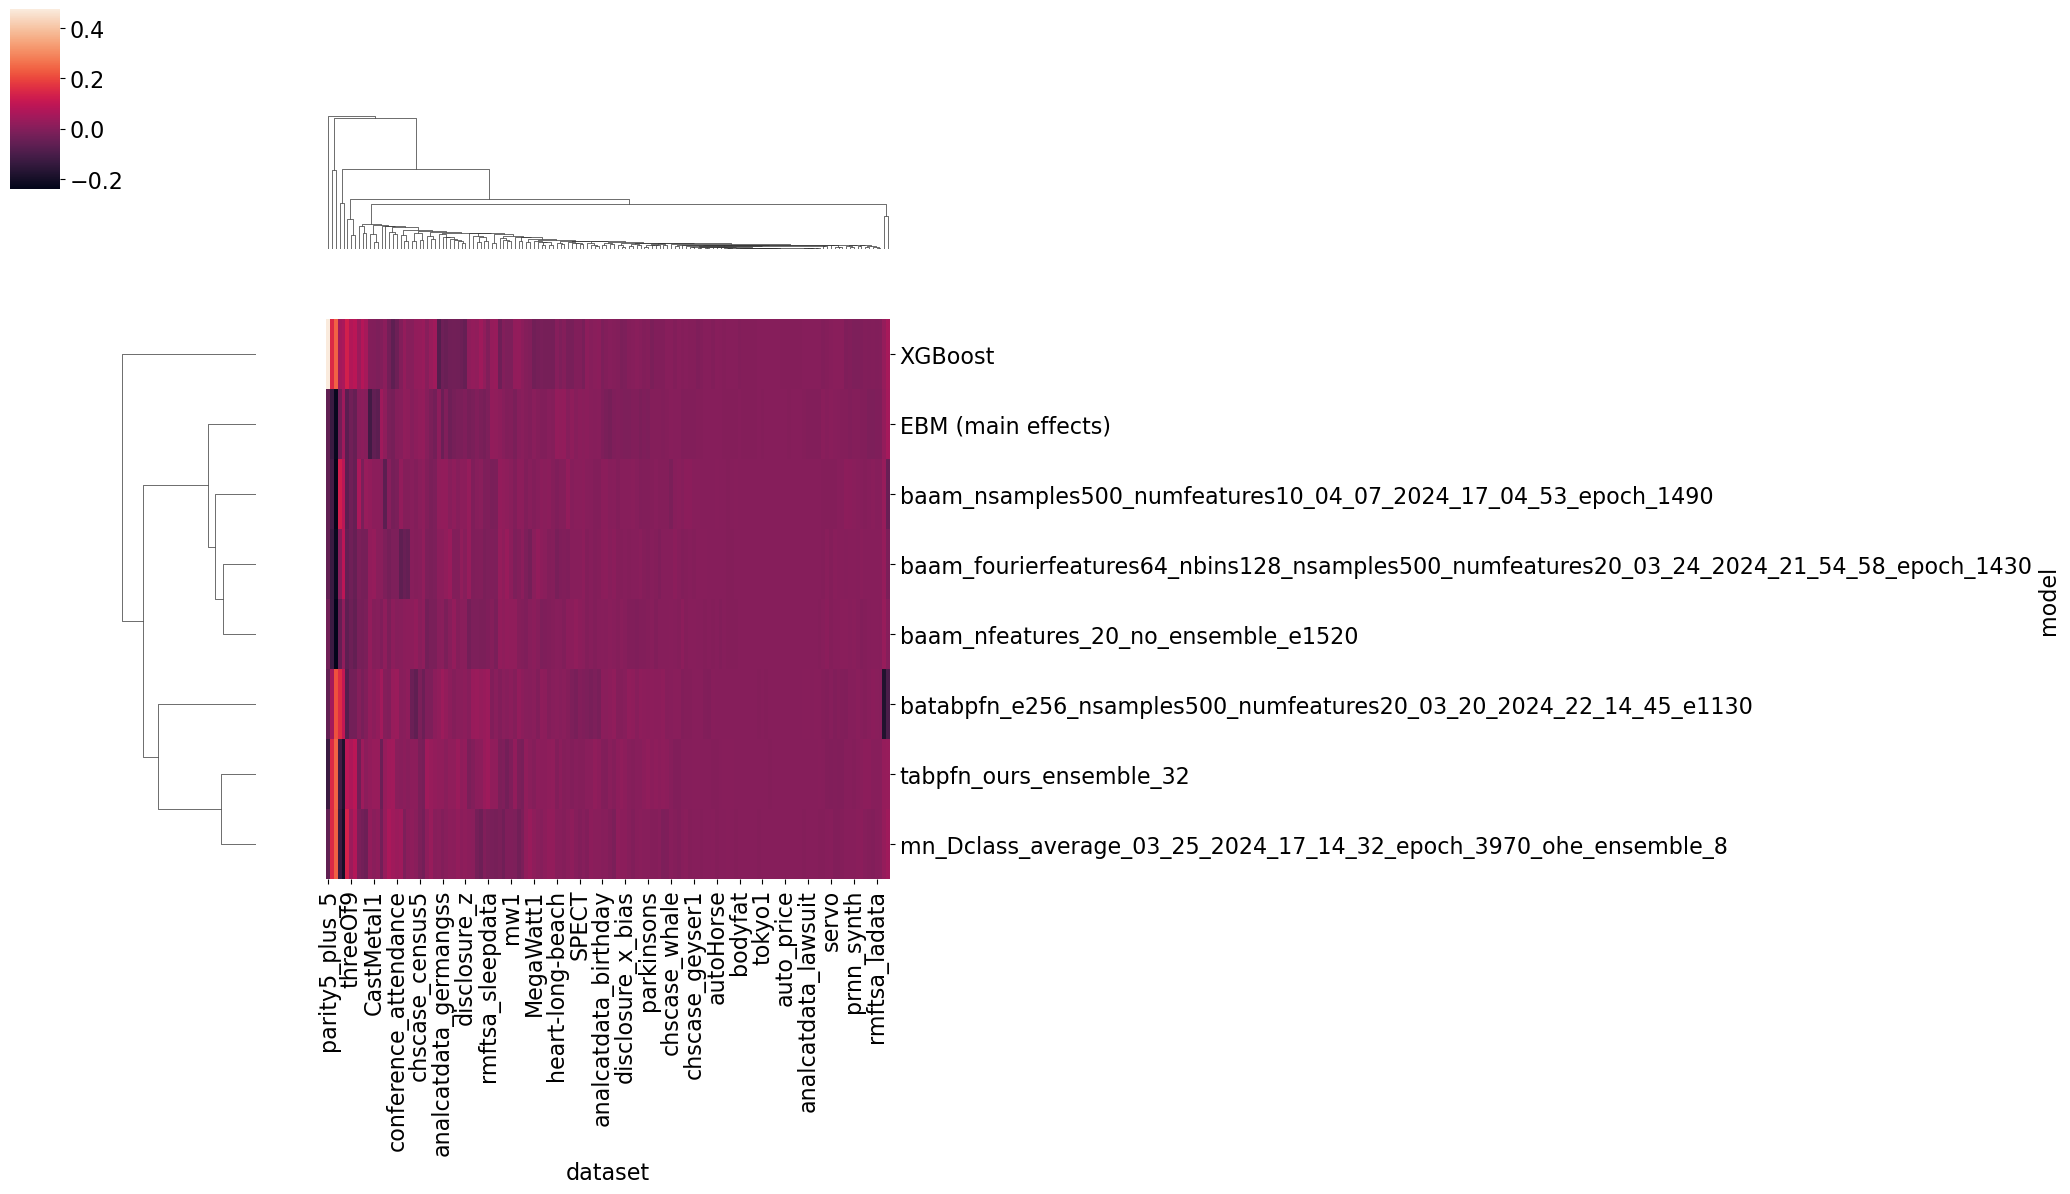

In [229]:
sns.clustermap(bla_normed2.T)